# The Optimal unsympatic Portfolio

## Aim of project and underlying assumptions:

The aim of this project is to find the optimal portfolio combination of the following stocks:

- AeroVironment, Inc. (AVAV)
- Ferrari N.V. (RACE)
- Las Vegas Sands (LVS)
- Tesla Motors (TSLA)

To find the optimal portfolio, we take an offset in Modern Portfolio Theory, finding the portfolio combination that bears the lowest risk i.e. the Minimum Variance Portolio (MVP).  To find the optimal portfolio, we furthermore make use of the Capital Asset Pricing Model (CAPM), which ultimately gives us the portfolio with the optimal ratio between expected return and risk i.e where we maximze the sharpe-ratio.  

In our model we make the following assumptions: 

- Investors are rational and risk-averse. 
- Historical returns is representative for future returns.
- Investors are price takers, meaning they cannot influence future prices.
- No transaction cost
- Investors can lend and borrow unlimited at the same risk free rate

Lastly we assume 253 trading days a year, and look at data from january 1st 2010 untill january 1st 2020 to make our estimations. Therfore our results will be showing the optimal portfolio per January 1st 2020. 





In [1]:
## packages and imports
import numpy as np
import pandas as pd
import datetime
import matplotlib.pyplot as plt
import ipywidgets as widgets
import scipy.stats as scs
import scipy.optimize as sco
import statsmodels.api as sm
import scipy.interpolate as sci
from pandas_datareader import data as pdr
import yfinance as yf

First we get all data into the file, and use the dividend-adjusted closing prices as the closing price for a given stock

In [2]:
# Time period and stocks: 
start_date = datetime.datetime(2010,1,1)
end_date = datetime.datetime(2020,1,1)
stocks = ["AVAV", "RACE","LVS","TSLA"]
num_stocks = len(stocks)


# get data as dataframe:
yf.pdr_override() 
data = pdr.get_data_yahoo(stocks, start=start_date, end=end_date)["Adj Close"]
data.iloc[np.r_[0:2, -2:0]]

# get risk free rate
risk_free_rate = pdr.get_data_yahoo("^TNX",start='2020-01-01',end='2020-01-01')["Adj Close"]
print(risk_free_rate)

[*********************100%***********************]  4 of 4 completed
[*********************100%***********************]  1 of 1 completed
Date
2019-12-31    1.919
Name: Adj Close, dtype: float64


Secondly we calculate daily returns as todays adj. closing price divided by yesterdays adj. closing price. We take the natural logarithm of this to show returns in percentage.

In [3]:
# Calculate log daily returns

log_daily_return = np.log(data / data.shift(1))
log_daily_return.iloc[np.r_[0:2, -2:0]]


AVAV       LVS      RACE      TSLA
Date                                              
2009-12-31       NaN       NaN       NaN       NaN
2010-01-04  0.018062  0.106564       NaN       NaN
2019-12-30  0.011696 -0.006329 -0.020479 -0.037113
2019-12-31 -0.016704 -0.003759  0.001451  0.008715

Now we plot cumulative returns, which shows us the performance of each individuals stock from 2010 to 2020. 

Text(0, 0.5, 'Cumulative return, in %')

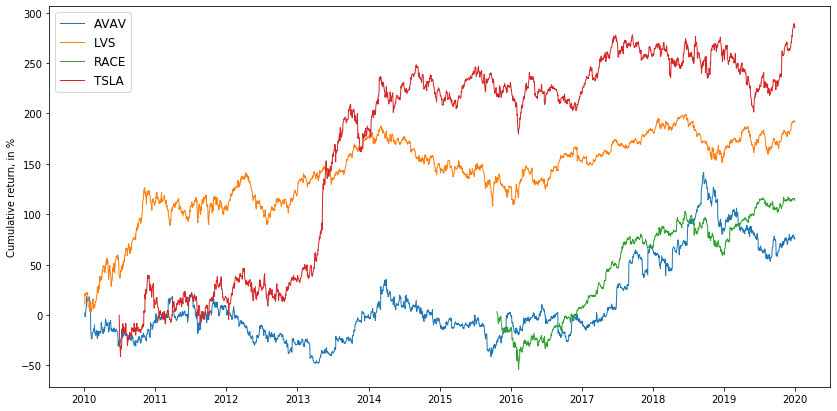

In [4]:
# log returns to avoid compound effect

################################################################

# stock performance
# evt kombinér stock performance + daily returns 

Performance = log_daily_return.cumsum() * 100
Performance.iloc[np.r_[0:2, -2:0]]


plt.figure(figsize=(14, 7))
for x in log_daily_return.columns.values:
    plt.plot(log_daily_return.index, Performance[x], lw=1, alpha=1, label=x)
plt.legend(fontsize=12)
plt.ylabel('Cumulative return, in %')

Below is the logged daily returns for each shock shown in a simple plot

Text(0, 0.5, 'Daily returns')

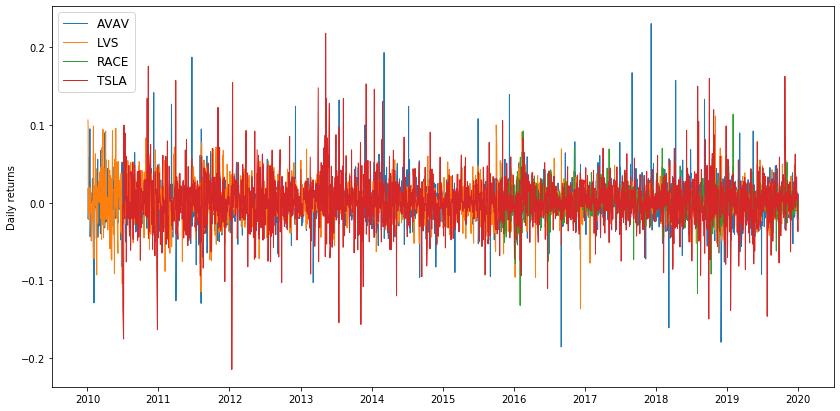

In [5]:
# plot log_daily_returns

plt.figure(figsize=(14, 7))
for c in log_daily_return.columns.values:
    plt.plot(log_daily_return.index, log_daily_return[c],lw=1, alpha=1, label=c)
plt.legend(fontsize=12)
plt.ylabel('Daily returns')

To find the expected returns and their corresponding variances, we calculate average return per year

In [6]:
yearly_trading_days = 253

# Mean returns, YoY

AY_return = log_daily_return.mean() * yearly_trading_days
Avg_yearly_return = pd.DataFrame()
Avg_yearly_return["Avg. annual return"] = AY_return 
Avg_yearly_return["Avg. annual return"] = pd.Series(["{0:.2f}%".format(val*100) for val in Avg_yearly_return['Avg. annual return']],index = Avg_yearly_return.index)
Avg_yearly_return

Avg. annual return
AVAV              7.57%
LVS              19.27%
RACE             27.33%
TSLA             30.27%

Based on our annual returns, we create a covariance matrix showing how each stock covariate meaning how one stocks react to a change of the price of another stock.

In [7]:
# Covariance Matrix with mean return

CovMatrix = log_daily_return.cov() * yearly_trading_days
CovMatrix

AVAV       LVS      RACE      TSLA
AVAV  0.161158  0.031635  0.023854  0.035864
LVS   0.031635  0.126548  0.030966  0.044943
RACE  0.023854  0.030966  0.087751  0.037584
TSLA  0.035864  0.044943  0.037584  0.263141

We know find the Weights as well as the expected return, variance and Standard Deviation before we can go into our Monte Carlo Simulation

In [8]:
weights = np.random.random(num_stocks)
weights /= np.sum(weights)
weights.sum()

np.sum(log_daily_return.mean() * weights) * yearly_trading_days
np.dot(weights.T, np.dot(log_daily_return.cov() * yearly_trading_days, weights))
np.sqrt(np.dot(weights.T, np.dot(log_daily_return.cov() * yearly_trading_days, weights)))

0.2897424861084173

# Simulation of portolio using Monte Carlo.

In [9]:
%%time
portfolio_return = [] 
portfolio_stdv = [] 

for p in range (10000):
 

 weights = np.random.random(num_stocks)
 weights /= np.sum(weights)
 
 portfolio_return.append(np.sum(log_daily_return.mean() * weights) * yearly_trading_days)

 portfolio_stdv.append(np.sqrt(np.dot(weights.T, np.dot(log_daily_return.cov() * yearly_trading_days, weights))))


portfolio_return = np.array(portfolio_return)
portfolio_stdv = np.array(portfolio_stdv)


Wall time: 20 s


Plotting all possible combinations of our portfolio

Text(0, 0.5, 'Expected Return of Portfolio')

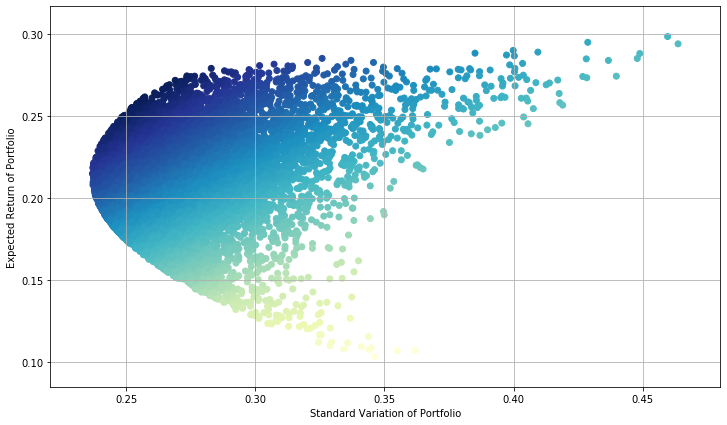

In [10]:
plt.figure(figsize=(12, 7))
plt.scatter(portfolio_stdv, portfolio_return, c = portfolio_return / portfolio_stdv, marker='o', cmap='YlGnBu')

plt.grid(True)
plt.xlabel('Standard Variation of Portfolio')
plt.ylabel('Expected Return of Portfolio')

The following is pure copy paste

In [41]:

def portfolio(weights):
 weights = np.array(weights)
 portfolio_return = np.sum(log_daily_return.mean() * weights) * yearly_trading_days # Portfolio annualized return
 portfolio_stdv = np.sqrt(np.dot(weights.T, np.dot(log_daily_return.cov() * yearly_trading_days, weights))) # Portfolio annualized standard deviation
 return np.array([portfolio_return, portfolio_stdv, portfolio_return / portfolio_stdv]) # Portfolio annualized return, Portfolio annualized standard deviation, Portfolio Sharpe ratio

In [12]:
def min_func_sharpe(weights):
 return -portfolio(weights)[2]

In [42]:
cons = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
#this is a dictionary with two objects which constrains the optimization
print(cons)

{'type': 'eq', 'fun': <function <lambda> at 0x000001CB09CC8598>}


In [43]:
bnds = tuple((0, 1) for x in range(num_stocks))

print(bnds)

((0, 1), (0, 1), (0, 1), (0, 1))


More copy paste to find the optimal sharpe ratio portfolio

In [44]:

opt_sharpe = sco.minimize(min_func_sharpe, num_stocks * [1. / num_stocks,], method='SLSQP', bounds=bnds, constraints=cons)

In [45]:
opt_sharpe

     fun: -1.0186666061382021
     jac: array([ 0.11822411, -0.00091511,  0.00037436, -0.00057204])
 message: 'Optimization terminated successfully.'
    nfev: 25
     nit: 4
    njev: 4
  status: 0
 success: True
       x: array([0.        , 0.16520035, 0.6643163 , 0.17048335])

In [46]:
print(opt_sharpe['x'].round(2))
print(stocks)
#creates nparray based on key 'x' from the optimization, and rounds to 3 digit

[0.   0.17 0.66 0.17]
['AVAV', 'RACE', 'LVS', 'TSLA']


In [47]:
portfolio(opt_sharpe['x']).round(2)

array([0.26, 0.26, 1.02])

In [49]:
round(opt_sharpe['x'].sum(),2)

1.0

Copy to find minimum variance portfolio

In [50]:

def min_func_variance(weights):
     return portfolio(weights)[1] ** 2 # portfolio variance

In [51]:
%%time
opt_variance = sco.minimize(min_func_variance, num_stocks * [1. / num_stocks,], method='SLSQP', bounds=bnds,
constraints=cons)

Wall time: 56.8 ms


In [52]:
opt_variance

     fun: 0.05608348189364118
     jac: array([0.11195554, 0.11222531, 0.1121587 , 0.11261478])
 message: 'Optimization terminated successfully.'
    nfev: 48
     nit: 8
    njev: 8
  status: 0
 success: True
       x: array([0.21308404, 0.25041807, 0.46003441, 0.07646348])

In [53]:
opt_variance['x'].round(3)

array([0.213, 0.25 , 0.46 , 0.076])

In [54]:
portfolio(opt_variance['x']).round(3)

array([0.213, 0.237, 0.9  ])

Even more copy to find the efficient frontier

The efficient frontier is found as the optimal portfolio at a given level of risk. This frontier contains a set of the most diversified portfolios possible with the given set of stocks. 

In [55]:

def min_func_port(weights):
     return portfolio(weights)[1] #portfolio function

In [56]:

cons = ({'type': 'eq', 'fun': lambda x: portfolio(x)[0] - target_return},
        {'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
bnds = tuple((0, 1) for x in weights)
#normal bounds for optimization

In [65]:

target_returns = np.linspace(0.1, 0.3, 50) # target return, within 10 % to 30 %, 50 samples
target_stdv = []
for target_return in target_returns:
 cons = ({'type': 'eq', 'fun': lambda x: portfolio(x)[0] - target_return}, {'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
 res = sco.minimize(min_func_port, num_stocks * [1. / num_stocks,], method='SLSQP', bounds=bnds, constraints=cons)
 target_stdv.append(res['fun'])
target_stdv = np.array(target_stdv)

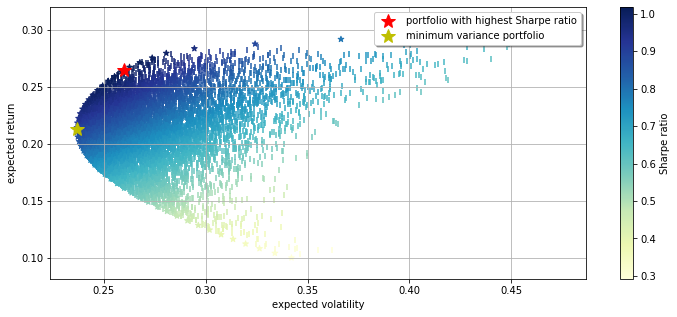

In [66]:
plt.figure(figsize=(12, 5))
plt.scatter(portfolio_stdv, portfolio_return,
 c=portfolio_return / portfolio_stdv, marker='|', cmap ='YlGnBu')
 # random portfolio composition
plt.scatter(target_stdv, target_returns,
 c=target_returns / target_stdv, marker='*', cmap='YlGnBu')
 # efficient frontier
plt.plot(portfolio(opt_sharpe['x'])[1], portfolio(opt_sharpe['x'])[0],
 'r*', markersize=15.0,label ='portfolio with highest Sharpe ratio')
 # portfolio with highest Sharpe ratio
plt.plot(portfolio(opt_variance['x'])[1], portfolio(opt_variance['x'])[0],
 'y*', markersize=15.0,label ='minimum variance portfolio')
 # minimum variance portfolio
plt.grid(True)
plt.xlabel('expected volatility')
plt.ylabel('expected return')
plt.colorbar(label='Sharpe ratio')
plt.legend(loc='upper right', shadow=True, ncol=1)

Capital market line (copy)

The Capital Market Line gives us all the possible combinations of our optimal portfolio and the risk-free investment. This line is the investor's opportunity to design a portfolio that suits their desire of risk and still hold the portfolio that maximizes return relative to risk. If we, for example, have an extremely risk-averse investor, then the person would purely hold the risk-free asset. On the other hand, if we see a risk-loving investor, then it will be possible to borrow at the risk-free rate and buy the optimal portfolio (i.e., where we have the highest Sharpe-Ratio), and achieve a higher expected return on the cost of bearing a higher level of risk. 

In [67]:
ind = np.argmin(target_stdv) # index number of portfolio 
efficient_stdv = target_stdv[ind:] # indexed portfolios volatility
efficient_returns = target_returns[ind:] # indexed portolfios return

In [68]:

tck = sci.splrep(efficient_stdv, efficient_returns) # Cubic splines interpolation based
                               # on the indexed portfolios' values of
                               # return and volatility

In [69]:
def f(x):
#Efficient frontier function (splines approximation)
 return sci.splev(x, tck, der=0)
def df(x):
#First derivative of efficient frontier function
 return sci.splev(x, tck, der=1)

In [70]:
def equations(z, rf):
    eq1 = rf - z[0]  
    eq2 = rf + z[1] * z[2] - f(z[2])
    eq3 = z[1] - df(z[2])
    return eq1, eq2, eq3

def riskfree(rf):
    return(sco.fsolve(equations, [0.01, 0.5, 0.15], rf))

In [71]:
riskfree(0.06)

array([0.06      , 0.79002059, 0.26544575])

In [72]:
def CAPM_FIGURE(rf, portfolio_stdv=portfolio_stdv, portfolio_return=portfolio_return , p=p ):
    plt.figure(figsize=(16, 8))
    plt.scatter(portfolio_stdv, portfolio_return,
    c=(portfolio_return - 0.01) / portfolio_stdv, marker='o', cmap='YlGnBu')
    # random portfolio composition
    plt.plot(efficient_stdv, efficient_returns, 'black', lw=3.0)
    # efficient frontier
    cx = np.linspace(0.0, 0.3)
    temp = riskfree(rf)  #making a temp, so it doesnt have to calculate riskfree over and over. 
    plt.plot(cx, temp[0] + temp[1] * cx, lw=2.0)
    # capital market line
    plt.plot(temp[2], f(temp[2]), 'r*', markersize=15.0)
    plt.grid(True)
    plt.axhline(0, color='k', ls='-', lw=2.0)
    plt.axvline(0, color='k', ls='-', lw=2.0)
    plt.ylim(-0.1 , 0.35)
    plt.xlabel('expected volatility')
    plt.ylabel('expected return')
    plt.colorbar(label='Sharpe ratio')
    plt.show()

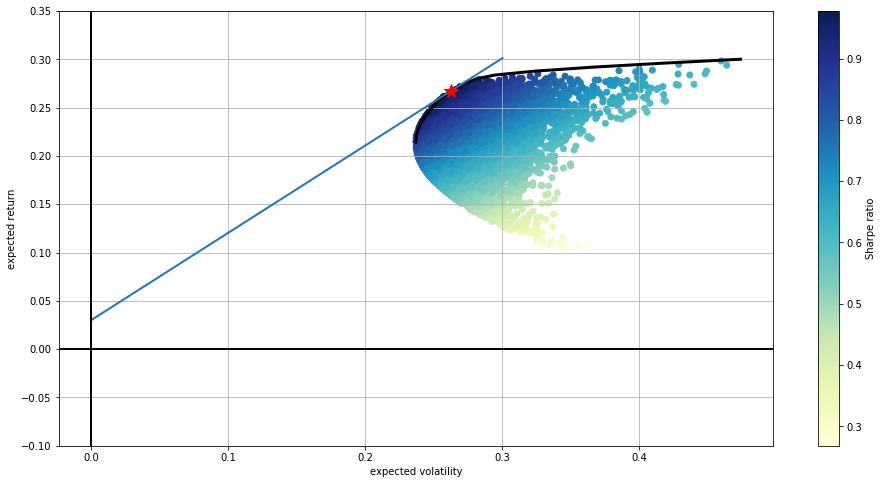

In [74]:
CAPM_FIGURE(0.03)

In [75]:
widgets.interact(CAPM_FIGURE,
                 rf = widgets.FloatSlider(description="$Riskfree$", min=-0.1, max=0.1, step=0.01, value=0),
                 portfolio_stdv = widgets.fixed(portfolio_stdv),
                 portfolio_return=widgets.fixed(portfolio_return),
                 p=widgets.fixed(p)
                );

###

interactive(children=(FloatSlider(value=0.0, description='$Riskfree$', max=0.1, min=-0.1, step=0.01), Output()…

In [ ]:
hej